In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score

from transformers import AdamW

# from transformers import BertTokenizer, BertConfig
# from transformers import BertForTokenClassification, AdamW

# from transformers import RobertaConfig, RobertaModel
# from transformers import RobertaTokenizer, RobertaForTokenClassification, AutoTokenizer, AdamW

from transformers import AutoTokenizer, AlbertForTokenClassification

2023-08-01 14:23:42.928022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 14:23:44.025719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('all.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

In [4]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")


In [5]:
def degreekify(char):
    #char will be a character
    greek = {'α': '[alpha]', 'β':'[beta]', 'γ': '[gamma]', 'δ':'[delta]', 'ε': '[epsilon]', 'ζ':'[zeta]', 'η': '[eta]',
            'θ':'[theta]', 'ι': '[iota]', 'κ':'[kappa]', 'λ':'[lambda]', 'μ': '[mu]', 'ν':'[nu]', 'ξ':'[xi]', 'ο':'[omicron]', 'π':'[pi]', 'ρ':'[rho]',
            'σ': '[sigma]', 'τ': '[tau]', 'υ':'[upsilon]', 'φ':'[phi]', 'χ':'[chi]', 'ψ':'[psi]', 'ω':'[omega]' }
    if char in greek:
        return greek[char]
    else:
        return char

In [6]:
def pre_process(text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    text_dict = []
    
    for i in range(len(text)):
        text_dict.append(degreekify(text[i]))
    
    
    
    ann_indices = []
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    
    
    
    if len(annotations)==0:
        ann_indices.append([[0, len(text)],0])
    else:
        ann_indices.append([[0, annotations[0]['start_offset']], 0])
        for i in range(len(annotations)-1):
            ann_indices.append([[annotations[i]['start_offset'], annotations[i]['end_offset']], data_tags.index(annotations[i]['label'])])
            ann_indices.append([[annotations[i]['end_offset'], annotations[i+1]['start_offset']], 0])
            
        ann_indices.append([[annotations[-1]['start_offset'], annotations[-1]['end_offset']], data_tags.index(annotations[-1]['label'])])
        ann_indices.append([[annotations[-1]['end_offset'], len(text)], 0])
         
    
    labels = []
    sentences = []
    for a in ann_indices:
        
        if a[0][1]-a[0][0] !=0:
            together = ''
            for i in range(a[0][0], a[0][1]):
                together += text_dict[i]
                
            toke = together.split()
            sentences.extend(toke)
            t = len(toke)
            if t != 0:
                temp = [data_tags[a[1]+1]] * t
                if a[1] != 0:
                    temp[0] = data_tags[a[1]]
                labels.extend(temp)
 
    return labels, sentences

In [7]:
def reduce(sent, label, slist, llist):
    lens = len(sent)
    if lens < 256:
        slist.append(sent)
        llist.append(label)
    else:
        t = lens//2
        return reduce(sent[:t], label[:t], slist, llist), reduce(sent[t:], label[t:], slist, llist)
    
    

In [8]:
#create labels
data_tags = ['0','0','Metal', 'M-cont' , 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield' , 'Y-cont', 'Separation Method' , 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont']

sent_test, label_test = [], []
sentences, labels = [], []

for i in range(len(info)):
    l, s = pre_process(info[i]['text'], info[i]['entities'])
  
    if i % 5 == 0:
        reduce(s,l,sent_test, label_test)
#         test_sent.append(s)
#         test_label.append(l)
    else:
        reduce(s,l,sentences, labels)
#         labels.append(l)
#         sentences.append(s)

data_tags = data_tags[1:]


In [9]:
print(5%5)

0


In [10]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'Metal', 'M-cont', 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield', 'Y-cont', 'Separation Method', 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont']
['0', 'Metal', 'M-cont', 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield', 'Y-cont', 'Separation Method', 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont', 'PAD']
{'0': 0, 'Metal': 1, 'M-cont': 2, 'Element': 3, 'E-cont': 4, 'Acid': 5, 'A-cont': 6, 'Yield': 7, 'Y-cont': 8, 'Separation Method': 9, 'S-cont': 10, 'Resin': 11, 'R-cont': 12, 'Method of Analysis': 13, 'T-cont': 14, 'pH': 15, 'P-cont': 16, 'Chemi

In [11]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [12]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [13]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 256 # 64 or 128 or ...
bs = 6 # batch size


In [14]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
     

In [15]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [16]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [17]:
# Load AlBERT Model
from transformers import AutoTokenizer, AutoModelForTokenClassification
model = AlbertForTokenClassification.from_pretrained(
    "albert-base-v2",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
    
)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForTokenClassification: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

In [18]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [19]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 6e-6, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
epochs = 100

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=30,
    num_training_steps=total_steps
)

# **Training**

In [21]:
def acc(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    
    for i in range(len(sentences)):
       
        
        s, l = tokenize_and_preserve_labels(sentences[i], labels[i])
    
        
        temp1 = []
     
        for j in range(len(s)):
            t = tokenizer.convert_tokens_to_ids(s[j])
            temp1.append(t)
            
        tokenized_sentence = temp1
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        a = accuracy_score(new_labels, labels[i])
        if a  >= max_a and i !=4:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",labels[i])
            print()
            print()
            if special == i:
                for j in range(len(sentences[i])):
                    print(sentences[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
        


In [22]:
def acc_test(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    
    for i in range(len(sent_test)):
       
        
        s, label_test[i] = tokenize_and_preserve_labels(sent_test[i], label_test[i])
    
        
        temp1 = []
     
        for j in range(len(s)):
            t = tokenizer.convert_tokens_to_ids(s[j])
            temp1.append(t)
            
        tokenized_sentence = temp1
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        a = accuracy_score(new_labels, label_test[i])
        if a  >= max_a and i !=4:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",label_test[i])
            print()
            print()
            if special == i:
                for j in range(len(sent_test[i])):
                    print(sent_test[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
        


In [23]:
from torch import nn
from transformers import Trainer
w = [.99, 0.0008, .0008, .99,.99, .0319, .0319, .0239, .0239, .0736, .0736, .0135, .0135, .0526, .0526, .0083, .0083, .0463, .0436, .0324, .0324, .0324, .014, .014, .0386, .0386, .0004, .0004, .0293, .0293, .0421, .0421]

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(w))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [24]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

max_test = 10

for e in trange(epochs, desc="Epoch"):
    
    
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = eval_loss
    test_acc.append(a)
    if a <= max_test:
        max_test = a
    elif max_test * 1.05 >= a and max_test < a:
        torch.save(model, "check.ck")
torch.save(model, "end.ck")    

Epoch:   0%|                                                                                                 | 0/100 [00:00<?, ?it/s]


Average train loss: 2.5388081073760986


Epoch:   1%|▉                                                                                        | 1/100 [00:06<10:29,  6.36s/it]


Validation loss: 1.4311250845591228
Validation Accuracy: 0.7728658536585366


Average train loss: 1.3362606248030295


Epoch:   2%|█▊                                                                                       | 2/100 [00:12<09:42,  5.94s/it]


Validation loss: 1.271888534228007
Validation Accuracy: 0.7680155210643016


Average train loss: 1.1515075128812056


Epoch:   3%|██▋                                                                                      | 3/100 [00:17<09:27,  5.85s/it]


Validation loss: 1.1315495371818542
Validation Accuracy: 0.7281042128603105


Average train loss: 0.9688240553324039


Epoch:   4%|███▌                                                                                     | 4/100 [00:23<09:18,  5.81s/it]


Validation loss: 0.9468965927759806
Validation Accuracy: 0.760670731707317


Average train loss: 0.7914157131543527


Epoch:   5%|████▍                                                                                    | 5/100 [00:29<09:10,  5.80s/it]


Validation loss: 0.7762661973635355
Validation Accuracy: 0.7634423503325942


Average train loss: 0.6685300710109564


Epoch:   6%|█████▎                                                                                   | 6/100 [00:35<09:03,  5.78s/it]


Validation loss: 0.6883291353782018
Validation Accuracy: 0.8001662971175166


Average train loss: 0.576579461304041


Epoch:   7%|██████▏                                                                                  | 7/100 [00:40<08:58,  5.79s/it]


Validation loss: 0.6073633084694544
Validation Accuracy: 0.8215077605321508


Average train loss: 0.49824773319638693


Epoch:   8%|███████                                                                                  | 8/100 [00:46<08:52,  5.79s/it]


Validation loss: 0.5488596806923548
Validation Accuracy: 0.8360587583148559


Average train loss: 0.4477314524925672


Epoch:   9%|████████                                                                                 | 9/100 [00:52<08:47,  5.79s/it]


Validation loss: 0.5155153075853983
Validation Accuracy: 0.8424334811529933


Average train loss: 0.39485274656460834


Epoch:  10%|████████▊                                                                               | 10/100 [00:58<08:41,  5.80s/it]


Validation loss: 0.4859170640508334
Validation Accuracy: 0.8501940133037694


Average train loss: 0.3533824332631551


Epoch:  11%|█████████▋                                                                              | 11/100 [01:04<08:36,  5.80s/it]


Validation loss: 0.4593633661667506
Validation Accuracy: 0.8576773835920177


Average train loss: 0.3205128237605095


Epoch:  12%|██████████▌                                                                             | 12/100 [01:09<08:31,  5.81s/it]


Validation loss: 0.45099159826834995
Validation Accuracy: 0.8568458980044346


Average train loss: 0.2901513304274816


Epoch:  13%|███████████▍                                                                            | 13/100 [01:15<08:25,  5.81s/it]


Validation loss: 0.43380506585041684
Validation Accuracy: 0.8686252771618626


Average train loss: 0.2664411939107455


Epoch:  14%|████████████▎                                                                           | 14/100 [01:21<08:20,  5.82s/it]


Validation loss: 0.42852633943160373
Validation Accuracy: 0.8712583148558758


Average train loss: 0.23993567556429368


Epoch:  15%|█████████████▏                                                                          | 15/100 [01:27<08:14,  5.82s/it]


Validation loss: 0.42149584243694943
Validation Accuracy: 0.8726441241685144


Average train loss: 0.21947933862415644


Epoch:  16%|██████████████                                                                          | 16/100 [01:33<08:09,  5.82s/it]


Validation loss: 0.4063716356952985
Validation Accuracy: 0.8776330376940134


Average train loss: 0.20355421569771492


Epoch:  17%|██████████████▉                                                                         | 17/100 [01:38<08:02,  5.82s/it]


Validation loss: 0.391639565428098
Validation Accuracy: 0.8808203991130821


Average train loss: 0.18575783732991952


Epoch:  18%|███████████████▊                                                                        | 18/100 [01:44<07:57,  5.82s/it]


Validation loss: 0.413633294403553
Validation Accuracy: 0.8786031042128604


Average train loss: 0.17289705689136797


Epoch:  19%|████████████████▋                                                                       | 19/100 [01:50<07:51,  5.82s/it]


Validation loss: 0.38323548436164856
Validation Accuracy: 0.8808203991130821


Average train loss: 0.16516072697077805

Validation loss: 0.3988513723015785
Validation Accuracy: 0.8815133037694013



Epoch:  20%|█████████████████▌                                                                      | 20/100 [01:56<07:58,  5.98s/it]


Average train loss: 0.15327093563973904

Validation loss: 0.39402339855829877
Validation Accuracy: 0.8871951219512195



Epoch:  21%|██████████████████▍                                                                     | 21/100 [02:03<07:57,  6.05s/it]


Average train loss: 0.1401955894409464

Validation loss: 0.4010915756225586
Validation Accuracy: 0.8768015521064302



Epoch:  22%|███████████████████▎                                                                    | 22/100 [02:09<07:54,  6.09s/it]


Average train loss: 0.13255527164213932

Validation loss: 0.3957352166374524
Validation Accuracy: 0.8795731707317073



Epoch:  23%|████████████████████▏                                                                   | 23/100 [02:15<07:51,  6.13s/it]


Average train loss: 0.1219473287033347


Epoch:  24%|█████████████████████                                                                   | 24/100 [02:21<07:38,  6.04s/it]


Validation loss: 0.41715024660031
Validation Accuracy: 0.8763858093126385


Average train loss: 0.11715018118803318

Validation loss: 0.39910993725061417
Validation Accuracy: 0.8795731707317073



Epoch:  25%|██████████████████████                                                                  | 25/100 [02:27<07:34,  6.06s/it]


Average train loss: 0.10820575672774933


Epoch:  26%|██████████████████████▉                                                                 | 26/100 [02:33<07:23,  6.00s/it]


Validation loss: 0.4130011449257533
Validation Accuracy: 0.8797117516629712


Average train loss: 0.10282382437099631


Epoch:  27%|███████████████████████▊                                                                | 27/100 [02:39<07:14,  5.95s/it]


Validation loss: 0.43416929493347806
Validation Accuracy: 0.8795731707317073


Average train loss: 0.09718591934786393


Epoch:  28%|████████████████████████▋                                                               | 28/100 [02:45<07:06,  5.92s/it]


Validation loss: 0.4287169724702835
Validation Accuracy: 0.8761086474501109


Average train loss: 0.09033960146972767


Epoch:  29%|█████████████████████████▌                                                              | 29/100 [02:50<06:59,  5.90s/it]


Validation loss: 0.4108086849252383
Validation Accuracy: 0.8805432372505543


Average train loss: 0.08584168069781019


Epoch:  30%|██████████████████████████▍                                                             | 30/100 [02:56<06:52,  5.89s/it]


Validation loss: 0.42196877549091977
Validation Accuracy: 0.8772172949002217


Average train loss: 0.08021281491248654


Epoch:  31%|███████████████████████████▎                                                            | 31/100 [03:02<06:46,  5.89s/it]


Validation loss: 0.4325943936904271
Validation Accuracy: 0.8813747228381374


Average train loss: 0.07520708417555746


Epoch:  32%|████████████████████████████▏                                                           | 32/100 [03:08<06:39,  5.88s/it]


Validation loss: 0.45689385135968524
Validation Accuracy: 0.8797117516629712


Average train loss: 0.0727708967259297


Epoch:  33%|█████████████████████████████                                                           | 33/100 [03:14<06:33,  5.87s/it]


Validation loss: 0.43852705011765164
Validation Accuracy: 0.8786031042128604


Average train loss: 0.06797531290123096


Epoch:  34%|█████████████████████████████▉                                                          | 34/100 [03:20<06:27,  5.87s/it]


Validation loss: 0.4318079923590024
Validation Accuracy: 0.8756929046563193


Average train loss: 0.06366871648396437


Epoch:  35%|██████████████████████████████▊                                                         | 35/100 [03:26<06:21,  5.86s/it]


Validation loss: 0.45293409874041873
Validation Accuracy: 0.875970066518847


Average train loss: 0.0605222936361455


Epoch:  36%|███████████████████████████████▋                                                        | 36/100 [03:31<06:15,  5.87s/it]


Validation loss: 0.4513173773884773
Validation Accuracy: 0.885809312638581


Average train loss: 0.058159609647611014


Epoch:  37%|████████████████████████████████▌                                                       | 37/100 [03:37<06:10,  5.87s/it]


Validation loss: 0.4513268272082011
Validation Accuracy: 0.8837305986696231


Average train loss: 0.056144024863337666


Epoch:  38%|█████████████████████████████████▍                                                      | 38/100 [03:43<06:03,  5.87s/it]


Validation loss: 0.4425835385918617
Validation Accuracy: 0.8815133037694013


Average train loss: 0.0523359460147241


Epoch:  39%|██████████████████████████████████▎                                                     | 39/100 [03:49<05:57,  5.87s/it]


Validation loss: 0.4499316265185674
Validation Accuracy: 0.884839246119734


Average train loss: 0.05070938886358188


Epoch:  40%|███████████████████████████████████▏                                                    | 40/100 [03:55<05:51,  5.86s/it]


Validation loss: 0.45893900096416473
Validation Accuracy: 0.8801274944567627


Average train loss: 0.04810973937408282


Epoch:  41%|████████████████████████████████████                                                    | 41/100 [04:01<05:45,  5.85s/it]


Validation loss: 0.45360072205464047
Validation Accuracy: 0.8815133037694013


Average train loss: 0.04501187350475588


Epoch:  42%|████████████████████████████████████▉                                                   | 42/100 [04:07<05:39,  5.86s/it]


Validation loss: 0.46141041318575543
Validation Accuracy: 0.8815133037694013


Average train loss: 0.04276878717624081


Epoch:  43%|█████████████████████████████████████▊                                                  | 43/100 [04:12<05:33,  5.85s/it]


Validation loss: 0.45963658144076663
Validation Accuracy: 0.8840077605321508


Average train loss: 0.040513386797661394


Epoch:  44%|██████████████████████████████████████▋                                                 | 44/100 [04:18<05:28,  5.86s/it]


Validation loss: 0.47122621287902194
Validation Accuracy: 0.8855321507760532


Average train loss: 0.0392398656023523


Epoch:  45%|███████████████████████████████████████▌                                                | 45/100 [04:24<05:22,  5.86s/it]


Validation loss: 0.4864400525887807
Validation Accuracy: 0.8820676274944568


Average train loss: 0.036714712713057034


Epoch:  46%|████████████████████████████████████████▍                                               | 46/100 [04:30<05:16,  5.86s/it]


Validation loss: 0.47683850179115933
Validation Accuracy: 0.8828991130820399


Average train loss: 0.03467253133511314


Epoch:  47%|█████████████████████████████████████████▎                                              | 47/100 [04:36<05:10,  5.87s/it]


Validation loss: 0.5073655272523562
Validation Accuracy: 0.8826219512195121


Average train loss: 0.033919444146494455


Epoch:  48%|██████████████████████████████████████████▏                                             | 48/100 [04:42<05:05,  5.87s/it]


Validation loss: 0.47727613896131516
Validation Accuracy: 0.8823447893569845


Average train loss: 0.0320878217731101


Epoch:  49%|███████████████████████████████████████████                                             | 49/100 [04:48<04:58,  5.85s/it]


Validation loss: 0.48443498462438583
Validation Accuracy: 0.8833148558758315


Average train loss: 0.031176426259872433


Epoch:  50%|████████████████████████████████████████████                                            | 50/100 [04:53<04:52,  5.84s/it]


Validation loss: 0.48219672093788785
Validation Accuracy: 0.8840077605321508


Average train loss: 0.028993190615437925


Epoch:  51%|████████████████████████████████████████████▉                                           | 51/100 [04:59<04:46,  5.85s/it]


Validation loss: 0.5047735174496969
Validation Accuracy: 0.8819290465631929


Average train loss: 0.027165550496787406


Epoch:  52%|█████████████████████████████████████████████▊                                          | 52/100 [05:05<04:40,  5.85s/it]


Validation loss: 0.4944906185070674
Validation Accuracy: 0.8810975609756098


Average train loss: 0.026712096851462357


Epoch:  53%|██████████████████████████████████████████████▋                                         | 53/100 [05:11<04:35,  5.86s/it]


Validation loss: 0.5030634999275208
Validation Accuracy: 0.8828991130820399


Average train loss: 0.0252614132164476


Epoch:  54%|███████████████████████████████████████████████▌                                        | 54/100 [05:17<04:29,  5.86s/it]


Validation loss: 0.5062213316559792
Validation Accuracy: 0.8815133037694013


Average train loss: 0.024017082672799006


Epoch:  55%|████████████████████████████████████████████████▍                                       | 55/100 [05:23<04:23,  5.86s/it]


Validation loss: 0.4991247206926346
Validation Accuracy: 0.8831762749445676


Average train loss: 0.022478176639057122


Epoch:  56%|█████████████████████████████████████████████████▎                                      | 56/100 [05:29<04:18,  5.86s/it]


Validation loss: 0.5076573739449183
Validation Accuracy: 0.8805432372505543


Average train loss: 0.02158844702017422


Epoch:  57%|██████████████████████████████████████████████████▏                                     | 57/100 [05:34<04:11,  5.86s/it]


Validation loss: 0.517665316661199
Validation Accuracy: 0.8815133037694013


Average train loss: 0.020985961352170516


Epoch:  58%|███████████████████████████████████████████████████                                     | 58/100 [05:40<04:05,  5.85s/it]


Validation loss: 0.5161253735423088
Validation Accuracy: 0.8827605321507761


Average train loss: 0.019829850093139194


Epoch:  59%|███████████████████████████████████████████████████▉                                    | 59/100 [05:46<04:00,  5.86s/it]


Validation loss: 0.5038235212365786
Validation Accuracy: 0.8820676274944568


Average train loss: 0.01888830540701747


Epoch:  60%|████████████████████████████████████████████████████▊                                   | 60/100 [05:52<03:54,  5.86s/it]


Validation loss: 0.5313646569848061
Validation Accuracy: 0.883869179600887


Average train loss: 0.018317863936177813


Epoch:  61%|█████████████████████████████████████████████████████▋                                  | 61/100 [05:58<03:48,  5.85s/it]


Validation loss: 0.5229402879873911
Validation Accuracy: 0.8842849223946785


Average train loss: 0.01795891423870881


Epoch:  62%|██████████████████████████████████████████████████████▌                                 | 62/100 [06:04<03:41,  5.84s/it]


Validation loss: 0.5202889318267504
Validation Accuracy: 0.8841463414634146


Average train loss: 0.016754517398882084


Epoch:  63%|███████████████████████████████████████████████████████▍                                | 63/100 [06:10<03:36,  5.85s/it]


Validation loss: 0.5282079949975014
Validation Accuracy: 0.884839246119734


Average train loss: 0.015822778558895852


Epoch:  64%|████████████████████████████████████████████████████████▎                               | 64/100 [06:15<03:30,  5.85s/it]


Validation loss: 0.5396213605999947
Validation Accuracy: 0.8817904656319291


Average train loss: 0.015049467978175156


Epoch:  65%|█████████████████████████████████████████████████████████▏                              | 65/100 [06:21<03:24,  5.85s/it]


Validation loss: 0.5226426621278127
Validation Accuracy: 0.8849778270509978


Average train loss: 0.014665342419623183


Epoch:  66%|██████████████████████████████████████████████████████████                              | 66/100 [06:27<03:19,  5.86s/it]


Validation loss: 0.52423907071352
Validation Accuracy: 0.8834534368070953


Average train loss: 0.013766052013334747


Epoch:  67%|██████████████████████████████████████████████████████████▉                             | 67/100 [06:33<03:12,  5.82s/it]


Validation loss: 0.5187048042813936
Validation Accuracy: 0.8841463414634146


Average train loss: 0.01366048284063044


Epoch:  68%|███████████████████████████████████████████████████████████▊                            | 68/100 [06:39<03:05,  5.79s/it]


Validation loss: 0.5229131355881691
Validation Accuracy: 0.8842849223946785


Average train loss: 0.01283138678319609


Epoch:  69%|████████████████████████████████████████████████████████████▋                           | 69/100 [06:44<02:59,  5.77s/it]


Validation loss: 0.5301949630180994
Validation Accuracy: 0.8859478935698448


Average train loss: 0.01218523720700222


Epoch:  70%|█████████████████████████████████████████████████████████████▌                          | 70/100 [06:50<02:52,  5.76s/it]


Validation loss: 0.5328059867024422
Validation Accuracy: 0.8853935698447893


Average train loss: 0.011891202544435285


Epoch:  71%|██████████████████████████████████████████████████████████████▍                         | 71/100 [06:56<02:46,  5.75s/it]


Validation loss: 0.5519896323482195
Validation Accuracy: 0.8853935698447893


Average train loss: 0.011018638969219934


Epoch:  72%|███████████████████████████████████████████████████████████████▎                        | 72/100 [07:02<02:40,  5.74s/it]


Validation loss: 0.5388344873984655
Validation Accuracy: 0.8823447893569845


Average train loss: 0.010929568632631205


Epoch:  73%|████████████████████████████████████████████████████████████████▏                       | 73/100 [07:07<02:34,  5.74s/it]


Validation loss: 0.5370777919888496
Validation Accuracy: 0.884839246119734


Average train loss: 0.01075959769794001


Epoch:  74%|█████████████████████████████████████████████████████████████████                       | 74/100 [07:13<02:29,  5.73s/it]


Validation loss: 0.5346926301717758
Validation Accuracy: 0.884839246119734


Average train loss: 0.010485285472196456


Epoch:  75%|██████████████████████████████████████████████████████████████████                      | 75/100 [07:19<02:23,  5.73s/it]


Validation loss: 0.5499608442187309
Validation Accuracy: 0.8844235033259423


Average train loss: 0.0098450196092017


Epoch:  76%|██████████████████████████████████████████████████████████████████▉                     | 76/100 [07:24<02:17,  5.73s/it]


Validation loss: 0.5438915019234022
Validation Accuracy: 0.8863636363636364


Average train loss: 0.009606846880230408


Epoch:  77%|███████████████████████████████████████████████████████████████████▊                    | 77/100 [07:30<02:11,  5.73s/it]


Validation loss: 0.5386246964335442
Validation Accuracy: 0.8849778270509978


Average train loss: 0.009257663562983418


Epoch:  78%|████████████████████████████████████████████████████████████████████▋                   | 78/100 [07:36<02:06,  5.73s/it]


Validation loss: 0.5525690093636513
Validation Accuracy: 0.8841463414634146


Average train loss: 0.00869653838274714


Epoch:  79%|█████████████████████████████████████████████████████████████████████▌                  | 79/100 [07:42<02:00,  5.73s/it]


Validation loss: 0.5459191625316938
Validation Accuracy: 0.884839246119734


Average train loss: 0.008585991837138023


Epoch:  80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [07:47<01:54,  5.73s/it]


Validation loss: 0.5508727629979452
Validation Accuracy: 0.8840077605321508


Average train loss: 0.008003186597936572


Epoch:  81%|███████████████████████████████████████████████████████████████████████▎                | 81/100 [07:53<01:48,  5.73s/it]


Validation loss: 0.5518672366937002
Validation Accuracy: 0.8853935698447893


Average train loss: 0.007721633527230902


Epoch:  82%|████████████████████████████████████████████████████████████████████████▏               | 82/100 [07:59<01:43,  5.73s/it]


Validation loss: 0.5524196376403173
Validation Accuracy: 0.8840077605321508


Average train loss: 0.007676437414304998


Epoch:  83%|█████████████████████████████████████████████████████████████████████████               | 83/100 [08:05<01:37,  5.73s/it]


Validation loss: 0.5409748951594034
Validation Accuracy: 0.8853935698447893


Average train loss: 0.007438668152854706


Epoch:  84%|█████████████████████████████████████████████████████████████████████████▉              | 84/100 [08:10<01:31,  5.73s/it]


Validation loss: 0.5546073218186697
Validation Accuracy: 0.885670731707317


Average train loss: 0.006936562883381087


Epoch:  85%|██████████████████████████████████████████████████████████████████████████▊             | 85/100 [08:16<01:25,  5.73s/it]


Validation loss: 0.5555488963921865
Validation Accuracy: 0.8855321507760532


Average train loss: 0.006949235071750501


Epoch:  86%|███████████████████████████████████████████████████████████████████████████▋            | 86/100 [08:22<01:20,  5.73s/it]


Validation loss: 0.5480540717641512
Validation Accuracy: 0.8860864745011087


Average train loss: 0.0070788147501074355


Epoch:  87%|████████████████████████████████████████████████████████████████████████████▌           | 87/100 [08:27<01:14,  5.73s/it]


Validation loss: 0.5554936652382215
Validation Accuracy: 0.8845620842572062


Average train loss: 0.006585180821555416


Epoch:  88%|█████████████████████████████████████████████████████████████████████████████▍          | 88/100 [08:33<01:08,  5.73s/it]


Validation loss: 0.5625130236148834
Validation Accuracy: 0.8859478935698448


Average train loss: 0.006643967841787694


Epoch:  89%|██████████████████████████████████████████████████████████████████████████████▎         | 89/100 [08:39<01:02,  5.73s/it]


Validation loss: 0.563649021089077
Validation Accuracy: 0.8844235033259423


Average train loss: 0.006311411638027773


Epoch:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 90/100 [08:45<00:57,  5.73s/it]


Validation loss: 0.5554672703146935
Validation Accuracy: 0.88470066518847


Average train loss: 0.006217689161600832


Epoch:  91%|████████████████████████████████████████████████████████████████████████████████        | 91/100 [08:50<00:51,  5.72s/it]


Validation loss: 0.5562413235505422
Validation Accuracy: 0.88470066518847


Average train loss: 0.006145041703488319


Epoch:  92%|████████████████████████████████████████████████████████████████████████████████▉       | 92/100 [08:56<00:45,  5.73s/it]


Validation loss: 0.5580582320690155
Validation Accuracy: 0.885670731707317


Average train loss: 0.005895524111110717


Epoch:  93%|█████████████████████████████████████████████████████████████████████████████████▊      | 93/100 [09:02<00:40,  5.73s/it]


Validation loss: 0.5648586377501488
Validation Accuracy: 0.8853935698447893


Average train loss: 0.005915672169066966


Epoch:  94%|██████████████████████████████████████████████████████████████████████████████████▋     | 94/100 [09:08<00:34,  5.73s/it]


Validation loss: 0.5604188516736031
Validation Accuracy: 0.8855321507760532


Average train loss: 0.005754010328718533


Epoch:  95%|███████████████████████████████████████████████████████████████████████████████████▌    | 95/100 [09:13<00:28,  5.73s/it]


Validation loss: 0.5611378227670988
Validation Accuracy: 0.8852549889135255


Average train loss: 0.00558896418974305


Epoch:  96%|████████████████████████████████████████████████████████████████████████████████████▍   | 96/100 [09:19<00:22,  5.73s/it]


Validation loss: 0.5615738555788994
Validation Accuracy: 0.885670731707317


Average train loss: 0.005681067054795746


Epoch:  97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 97/100 [09:25<00:17,  5.73s/it]


Validation loss: 0.5605032866199812
Validation Accuracy: 0.8852549889135255


Average train loss: 0.005471527247349373


Epoch:  98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [09:30<00:11,  5.73s/it]


Validation loss: 0.5630552147825559
Validation Accuracy: 0.8849778270509978


Average train loss: 0.005464715389490056


Epoch:  99%|███████████████████████████████████████████████████████████████████████████████████████ | 99/100 [09:36<00:05,  5.73s/it]


Validation loss: 0.5643747200568517
Validation Accuracy: 0.8852549889135255


Average train loss: 0.005358648261440417


Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:42<00:00,  5.82s/it]


Validation loss: 0.5635554393132528
Validation Accuracy: 0.8851164079822617



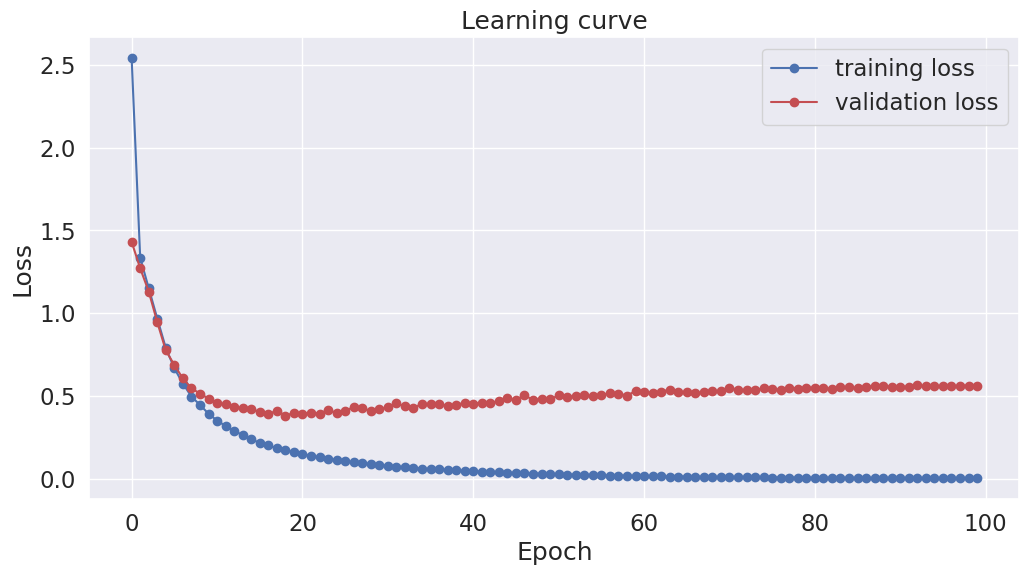

In [25]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [32]:
q = len(labels) -1
print(acc(False, q))
acc(True, q)


308 1.0
0.8527967177265322
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


___________________1___________________

Predict labels:  ['Element', 'Element', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', 'Element', 'Element', '0', '0'

___________________14___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '

___________________32___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', '0', 'Chemical Compound', 'Acid', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0'

___________________51___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________71___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


___________________72___________________

Pre

___________________92___________________

Predict labels:  ['0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Element Group', 'Acid', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', 'Element Group', 'Element Group', 'Element Group', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R-cont', 'R-cont', 'R-cont', 'R-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element Group', 'Element Group', 'Element Group', '0', '0', 'Element Group', 'Element Group', '0', '0', '0', '0', '0', 'R-cont', 'R-cont', 'R-cont', 'R-cont', 'R-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Elem

___________________114___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element'

___________________133___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Acid Concentration', 'Acid Concentration', 'Acid Concentration', 'Acid Concentration', 'Ac

___________________155___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield', 'Yield', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0'

___________________175___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Element Group', 'Element Group', 'Element Group', '0', '0', 'Element Group', 'Element Group', 'Element Group', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Acid', 'Acid', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont

___________________197___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

___________________219___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', 'Element', 'Element', 'E

___________________236___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0'

___________________255___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Element', '0', '0', 'Element', 'Element', '0', '0', 'Element', '0', '0', 'Element', 'El

___________________271___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', 'Organic solvent', 'Separation Method', 'Separation Method', '0', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element Group', 'Element Group', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0',

___________________286___________________

Predict labels:  ['0', '0', '0', '0', 'Element', 'Element', '0', '0', 'Element', 'Element', 'Element', '0', '0', 'Element', '0', '0', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Reagent', 'Reagent', 'Reagent', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Reagent', 'Reagent', 'Reagent', '0', '0', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', 'Reagent', '0', '0

___________________300___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', 'Resin', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Resin', 'Resin', 'Resin', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Resin', 'Resin', 'Resin', 'Resin', '0', '0', '0', '0',

___________________317___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Reagent', 'Reagent', '0', 'Reagent', 'Reagent', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '

___________________334___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0

0.8527967177265322

In [33]:
t = len(label_test) -1
print(acc_test(False, t))
print(acc_test(True, t))

37 1.0
0.6526122178962113
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', 'Acid', 'Acid', 'Acid', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', '0', 'Organic solvent', 'Organic solvent', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'Inorganic Solvent', '0', '0', '0', '0', '0', 'A-cont', 'A-cont', 'A-cont', '0', '0', 'A-cont', 'A-cont', 'A-cont', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', 'Element', 'Element', 'Element', '0', 'Organic solvent', 'Organic solvent', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', '0', '0', '0', '0

___________________16___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', 'Element', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

___________________35___________________

Predict labels:  ['0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'H-cont', 'H-cont', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

___________________56___________________

Predict labels:  ['Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Element', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Element', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________73___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

In [30]:
model = torch.load("test.ck")
model.eval()

print(acc_test(False, t))
print(acc_test(True, t))

37 1.0
0.6555041514975402
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', 'Acid', 'Acid', 'Acid', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', '0', 'Organic solvent', 'Organic solvent', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'Inorganic Solvent', '0', '0', '0', '0', '0', 'A-cont', 'A-cont', 'A-cont', '0', '0', 'A-cont', 'A-cont', 'A-cont', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', 'Element', 'Element', 'Element', '0', 'Organic solvent', 'Organic solvent', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', '0', '0', '0', '0

___________________16___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', 'Element', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

___________________35___________________

Predict labels:  ['0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'H-cont', 'H-cont', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', 'Chemical Comp

___________________56___________________

Predict labels:  ['Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Element', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Element', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________73___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

In [31]:
q = len(labels)
print(acc(False, q))
acc(True, q)

308 1.0
0.8527967177265322
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


___________________1___________________

Predict labels:  ['Element', 'Element', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', 'Element', 'Element', '0', '0'

___________________14___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '

___________________32___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', '0', 'Chemical Compound', 'Acid', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0'

___________________51___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________71___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


___________________72___________________

Pre

___________________92___________________

Predict labels:  ['0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Element Group', 'Acid', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', 'Element Group', 'Element Group', 'Element Group', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R-cont', 'R-cont', 'R-cont', 'R-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element Group', 'Element Group', 'Element Group', '0', '0', 'Element Group', 'Element Group', '0', '0', '0', '0', '0', 'R-cont', 'R-cont', 'R-cont', 'R-cont', 'R-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Elem

___________________114___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element'

___________________133___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Acid Concentration', 'Acid Concentration', 'Acid Concentration', 'Acid Concentration', 'Ac

___________________155___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield', 'Yield', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0'

___________________175___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Element Group', 'Element Group', 'Element Group', '0', '0', 'Element Group', 'Element Group', 'Element Group', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Acid', 'Acid', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont

___________________197___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

___________________219___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', 'Element', 'Element', 'E

___________________236___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0'

___________________254___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', 'Separatio

___________________270___________________

Predict labels:  ['0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', 'Acid Concentration', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'Acid Concentration', 'Acid Concentration', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Elemen

___________________285___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'Inorganic Solvent', 'In

___________________299___________________

Predict labels:  ['S-cont', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Element', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', '0', 'Element', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Separat

___________________317___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Reagent', 'Reagent', '0', 'Reagent', 'Reagent', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', 'Reagent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '

___________________334___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0

0.8527967177265322